<a href="https://colab.research.google.com/github/yyyyyokoko/590FaceMaskDetection/blob/master/590_MobileNetV2_for_mask_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os, random
import pathlib
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Sequential
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2, VGG16, VGG19
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

import cv2

from tensorflow.keras.models import load_model



In [ ]:
!ls "/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/sample_training"

mask  nomask


In [ ]:
data_train = '/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/Validation/'
data_train

'/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/Validation/'

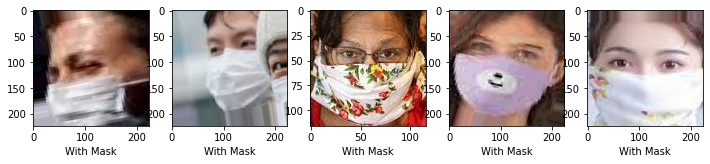

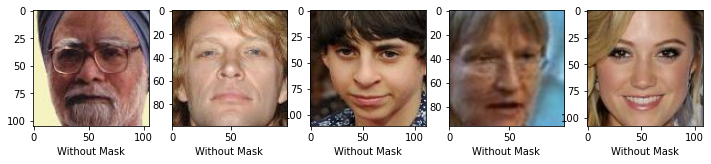

In [ ]:
#with Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"mask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"mask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("With Mask")
    plt.imshow(img)
plt.show()

#without Mask
plt.figure(figsize=(12,7))
for i in range(5):
    sample = random.choice(os.listdir(data_train+"nomask/"))
    plt.subplot(1,5,i+1)
    img = load_img(data_train+"nomask/"+sample)
    plt.subplots_adjust(hspace=0.001)
    plt.xlabel("Without Mask")
    plt.imshow(img)
plt.show()

In [ ]:
train_datagen = ImageDataGenerator(
        rotation_range=20,
        zoom_range=0.10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.15,
        rescale=1./255,
        horizontal_flip=True,
        validation_split=0.2)

train = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset = "training")


valid = train_datagen.flow_from_directory(directory=data_train,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32,subset="validation")

Found 526 images belonging to 2 classes.
Found 130 images belonging to 2 classes.


In [ ]:
valid.class_indices

{'mask': 1, 'nomask': 0}

In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(160, 160, 3)), classifier_activation="sigmoid")

for layer in baseModel.layers:
    layer.trainable = False

model = Sequential()
model.add(baseModel)
model.add(Flatten())
model.add(Dense(2,activation="sigmoid"))


In [ ]:

model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 5, 5, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 25602     
Total params: 14,740,290
Trainable params: 25,602
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics ="accuracy")


In [ ]:
checkpoint = ModelCheckpoint("moblenet_facemask.h5",monitor="val_accuracy",save_best_only=True,verbose=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit_generator(train,
                              epochs=10,
                              validation_data=valid,
                              callbacks=[checkpoint])


Epoch 1/10
17/17 [==============================] - ETA: 0s - loss: 0.4026 - accuracy: 0.8574
Epoch 00001: val_accuracy improved from -inf to 0.98462, saving model to moblenet_facemask.h5
17/17 [==============================] - 154s 9s/step - loss: 0.4026 - accuracy: 0.8574 - val_loss: 0.2003 - val_accuracy: 0.9846
Epoch 2/10
17/17 [==============================] - ETA: 0s - loss: 0.1388 - accuracy: 0.9715
Epoch 00002: val_accuracy did not improve from 0.98462
17/17 [==============================] - 5s 303ms/step - loss: 0.1388 - accuracy: 0.9715 - val_loss: 0.1235 - val_accuracy: 0.9692
Epoch 3/10
17/17 [==============================] - ETA: 0s - loss: 0.1014 - accuracy: 0.9791
Epoch 00003: val_accuracy did not improve from 0.98462
17/17 [==============================] - 5s 309ms/step - loss: 0.1014 - accuracy: 0.9791 - val_loss: 0.0831 - val_accuracy: 0.9769
Epoch 4/10
17/17 [==============================] - ETA: 0s - loss: 0.0764 - accuracy: 0.9810
Epoch 00004: val_accuracy di

### Evaluation 

In [ ]:
import pandas as pd
training_accuary = pd.DataFrame.from_dict(history.history).drop(columns = ['val_loss', 'val_accuracy'])

test_data = "/content/drive/My Drive/Colab Notebooks/Face Mask Dataset/sample_training"
test = train_datagen.flow_from_directory(directory=test_data,target_size=(160,160),
                                          class_mode="categorical",
                                          classes={'nomask': 0, 'mask': 1},
                                          batch_size=32)
model.evaluate(valid)

Found 96 images belonging to 2 classes.
5/5 [==============================] - 1s 154ms/step - loss: 0.0363 - accuracy: 0.9923


[0.03628474101424217, 0.9923076629638672]

In [ ]:
model.evaluate(train)

17/17 [==============================] - 4s 239ms/step - loss: 0.0374 - accuracy: 0.9943


[0.0373658649623394, 0.9942965507507324]

In [ ]:
model.evaluate(test)

3/3 [==============================] - 17s 6s/step - loss: 0.0987 - accuracy: 0.9688


[0.09874863177537918, 0.96875]

In [ ]:
training_accuary



,loss,accuracy
0,0.402645,0.857414
1,0.138848,0.971483
2,0.101421,0.979087
3,0.076382,0.980989
4,0.063713,0.986692
5,0.057105,0.992395
6,0.061103,0.986692
7,0.051049,0.990494
8,0.035826,0.998099
9,0.028993,0.998099


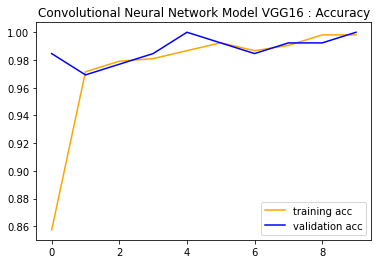

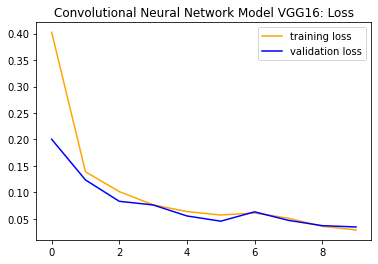

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, '-', color='orange', label='training acc')
plt.plot(epochs, val_acc, '-', color='blue', label='validation acc')
plt.title('Convolutional Neural Network Model VGG16 : Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, loss, '-', color='orange', label='training loss')
plt.plot(epochs, val_loss,  '-', color='blue', label='validation loss')
plt.title('Convolutional Neural Network Model VGG16: Loss')
plt.legend()
plt.show()

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/model_vgg16.h5")


In [ ]:
model = load_model('/content/drive/My Drive/Colab Notebooks/model_vgg16.h5')

pred = model.predict_classes(valid)
pred

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1])

In [ ]:
pred_probs = model.predict(valid)
pred_probs[:10]

array([[9.7137916e-01, 8.6945873e-03],
       [9.8746103e-01, 7.7770837e-03],
       [1.6234460e-04, 9.9995148e-01],
       [1.0596199e-02, 9.9567968e-01],
       [9.9989200e-01, 6.5261935e-05],
       [9.9784231e-01, 9.5375208e-04],
       [7.1755531e-03, 9.9607867e-01],
       [1.4946131e-03, 9.9950171e-01],
       [1.0770064e-02, 9.8790991e-01],
       [9.8833174e-01, 7.6585691e-03]], dtype=float32)